In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# dataset_folder = "datasets/financial"
# dataset_folder = "datasets/healthcare"
dataset_folder = "datasets/eligibility"

# Init memories

In [3]:
import os

from cama.memory import WorkingMemory, EpisodicMemory, SemanticMemory
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import json

from docarray import BaseDoc, DocList
from typing import Tuple, List
from rich import print



df_reference = pd.read_csv(f"{dataset_folder}/initial.csv")
df_current = pd.read_csv(f"{dataset_folder}/drifted.csv")

with open(f'{dataset_folder}/dataset_description.json', 'r') as f:
    dataset_description = json.load(f)

# Split initial dataset into training and testing sets
label_name = dataset_description["LABEL"]
X_reference = df_reference.drop(columns=[label_name])
y_reference = df_reference[label_name]
X_train_reference, X_test_reference, y_train_reference, y_test_reference = train_test_split(X_reference, y_reference, test_size=0.2, random_state=42)

# Split drifted dataset into training and testing sets
X_current = df_current.drop(columns=[label_name])
y_current = df_current[label_name]
X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(X_current, y_current, test_size=0.2, random_state=42)

X_train_reference.head()

/home/guess/mambaforge/envs/dspy/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


,Age,Income,Education Level,Employment Status,Marital Status
29,39,51755.0,2,1,0
535,51,39430.0,2,2,1
695,47,37106.0,2,1,1
557,47,37106.0,1,1,1
836,43,33641.0,2,1,1


In [4]:
from sklearn.ensemble import RandomForestClassifier

model_reference = RandomForestClassifier(random_state=42)
model_reference.fit(X_train_reference, y_train_reference)

# Test the model on the initial test set
initial_accuracy = model_reference.score(X_test_reference, y_test_reference)
print(f'Model trained and evaluated on the reference distribution: {initial_accuracy}')

Model trained and evaluated on the reference distribution: 0.775

## Episodic memory

In [5]:
from cama.memory import CurrentDataset


current_dataset = CurrentDataset(X=X_test_current, y_current=None, description=dataset_description)
first_episodic_memory = EpisodicMemory(current_dataset=current_dataset, task=0)
init_episodic_memory = DocList[EpisodicMemory]([first_episodic_memory])
# episodic_memory[0]


## Semantic memory

In [6]:
from cama.tools import get_tools
from cama.tools import get_drift_report, get_shap_values
from cama.memory import ReferenceDataset


tools = get_tools([get_drift_report, get_shap_values])


# At the beginning, the agent has 1 entry in the semantic memory. 
reference_dataset = ReferenceDataset(X_train=X_train_reference, 
                                     X_test=X_test_reference, 
                                     y_train=y_train_reference, 
                                     y_test=y_test_reference, 
                                     description=dataset_description)

init_semantic_memory = SemanticMemory(reference_dataset=reference_dataset, 
                                 tools=tools, model=model_reference)
# semantic_memory

## Dataset representation

In [7]:
from cama.representation import get_dataset_representation

get_drift_report_function = init_semantic_memory.tools['get_drift_report'].function
get_shap_values_report_function = init_semantic_memory.tools['get_shap_values'].function

drift_report = get_drift_report_function(init_semantic_memory.reference_dataset.description,
                                         init_semantic_memory.reference_dataset.X_train,
                                         init_episodic_memory[0].current_dataset.X,
                                         drift_share=0.7,
                                         show_plot=False)['drift_by_columns']

shap_report_train_reference = get_shap_values_report_function(init_semantic_memory.model,
                                                                init_semantic_memory.reference_dataset.X_train,
                                                                init_semantic_memory.reference_dataset.description)
shap_report_test_current = get_shap_values_report_function(init_semantic_memory.model,
                                                            init_episodic_memory[0].current_dataset.X,
                                                            init_episodic_memory[0].current_dataset.description)

shap_report = {feature: {'reference': shap_report_train_reference[feature], 'current': shap_report_test_current[feature]} for feature in shap_report_train_reference}
tools_results = {'get_drift_report': drift_report, 'get_shap_values': shap_report}


dataset_representation = get_dataset_representation(init_semantic_memory, tools_results)
# dataset_representation

# Generate/Load ground truth report

In [8]:
from cama.utils import get_ground_truth_template, generate_ground_truth_prompt

gt_template = get_ground_truth_template(init_semantic_memory,
                                        init_episodic_memory, 
                                        dataset_representation)
gt_prompt = generate_ground_truth_prompt(gt_template)
print(gt_prompt.format())

System: 
    You are an expert in data science and machine learning. Read the following report and complete it by filling 
inside the text '(Here the LLM should provide...)' with your explanations. Keep all the remaining text as it is.


# Comprehensive Report

## Executive Summary

(Here the LLM should provide an executive summary of the report.)

## Dataset Synopsis
**Title**: Eligibility Simulation Data  
**Features Analyzed**: Age, Income, Education Level, Employment Status, Marital Status
**Label Variable**: ProgramEligibility  

This dataset simulates the eligibility of individuals for a specific program, focusing on attributes such as Age, 
Income, Education Level, Employment Status, and Marital Status. The 'ProgramEligibility' variable serves as the 
label, indicating whether an individual is eligible (1) or not eligible (0) for the program. 


## Label Description
**ProgramEligibility**: Indicates eligibility for a specific program, with 0 representing not eligible and 1 
representing eligible, serving as the label variable for predictions.
(Here the LLM should provide an explanation if the label has issues or not. Remember that the label was not used in
the drift analysis and SHAP values.)

## Feature Analysis

### Feature name: Age
- **Description**: Age of the individual in years, ranging from 18 to 65.
- **Type**: Numerical
- **Possible Values**: Ranging from 18 to 65 years.
- **Data Type**: int

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.06325575780482698
- **Detection**: No drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [24.0, 27.4, 30.8, 34.2, 37.6, 41.0, 44.4, 47.8, 51.2, 
54.599999999999994, 58.0], 'y': [0.010294117647058827, 0.0264705882352941, 0.03970588235294115, 
0.038235294117647076, 0.039705882352941195, 0.06911764705882356, 0.027941176470588247, 0.02499999999999996, 
0.01029411764705885, 0.007352941176470575]}}
  - Reference: {'small_distribution': {'x': [18.0, 22.7, 27.4, 32.1, 36.8, 41.5, 46.2, 50.9, 55.6, 
60.300000000000004, 65.0], 'y': [0.0007978723404255321, 0.0053191489361702135, 0.02313829787234041, 
0.03085106382978726, 0.05265957446808508, 0.04893617021276593, 0.025265957446808533, 0.018351063829787222, 
0.005851063829787231, 0.0015957446808510653]}}
  - Interpretation: (Here the LLM should provide an interpretation of the current vs reference distribution. Gives 
examples of the differences.)

#### Feature Attribution Analysis
  - Method: Tree SHAP
  - Training Data: 0.1675692700443467 (Rank 2)
  - Current Data: 0.10098040394127042 (Rank 2)
  - Interpretation: (Here the LLM should provide an interpretation of the current vs reference SHAP values.)

#### Overal Interpretation**: 
  (Here the LLM should provide an overall interpretation for the feature: Age.)

### Feature name: Income
- **Description**: Annual income of the individual in thousands of dollars, indicating economic status, ranging 
from 20k to 70k.
- **Type**: Numerical
- **Possible Values**: Ranging from $20,000 to $70,000.
- **Data Type**: float

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.7978008461594442
- **Detection**: Drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [-3508.2364074368093, 10667.570547951202, 24843.377503339212, 
39019.18445872722, 53194.99141411523, 67370.79836950325, 81546.60532489125, 95722.41228027927, 109898.21923566727, 
124074.02619105528, 138249.8331464433], 'y': [1.4108544270489167e-06, 4.5852768879089795e-06, 
8.465126562293502e-06, 1.6577539517824768e-05, 1.8693821158398144e-05, 1.022869459610465e-05, 
5.643417708195664e-06, 2.468995247335605e-06, 1.7635680338111466e-06, 7.05427213524458e-07]}}
  - Reference: {'small_distribution': {'x': [21687.0, 26395.8, 31104.6, 35813.4, 40522.2, 45231.0, 49939.8, 
54648.6, 59357.4, 64066.200000000004, 68775.0], 'y': [2.389143730886851e-0

In [9]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from cama.utils import generate_ground_truth_prompt
from cama.utils import extract_markdown
from cama.utils import save_to_file
from cama.utils import load_from_file

load_dotenv('env')

openai_llm = ChatOpenAI(temperature=0.7, model_name="gpt-4o", cache=False)
 
gt_prompt = generate_ground_truth_prompt(gt_template)


file_name = 'gt_report.md'
# Save to file if it doesn't exist
file_path = f'{dataset_folder}/{file_name}'

if os.path.exists(file_path):
    print(f"{file_path} already exists. Loading from file.")
    gt_report = load_from_file(file_path)
else: 
    print(f"Invoking the pipeline to generate the ground truth report.")
    chain = gt_prompt | openai_llm | extract_markdown
    gt_report = chain.invoke({})#.content
    print(f"Saving the ground truth report to {file_path}")
    save_to_file(gt_report, file_path)

# print(gt_report)


datasets/eligibility/gt_report.md already exists. Loading from file.

# Generate/Load queries and answers

In [10]:
from cama.utils import generate_mchoice_qa_prompt, extract_json

number_qa = 40
qa_prompt = generate_mchoice_qa_prompt(gt_report, number_qa)
print(qa_prompt.format())

System: You are an expert in data science.
Human: 
    Generate 40 detailed multiple-choice questions and concise answers based on the following comprehensive report.
    Each question should have five options (A, B, C, D, E) and should cover various aspects of the report. Ensure 
the correct answer is clearly indicated and is unique. 
    Make sure to include numerical comparisons and insights drawn from the current and reference distributions 
wherever applicable:


    # Comprehensive Report

## Executive Summary

This report analyzes the eligibility simulation data to determine how different features such as Age, Income, 
Education Level, Employment Status, and Marital Status affect the ProgramEligibility. By utilizing distribution 
drift analysis and SHAP values, we aim to identify changes in the data distribution and the significance of each 
feature in predicting eligibility.

## Dataset Synopsis
**Title**: Eligibility Simulation Data  
**Features Analyzed**: Age, Income, Education Level, Employment Status, Marital Status
**Label Variable**: ProgramEligibility  

This dataset simulates the eligibility of individuals for a specific program, focusing on attributes such as Age, 
Income, Education Level, Employment Status, and Marital Status. The 'ProgramEligibility' variable serves as the 
label, indicating whether an individual is eligible (1) or not eligible (0) for the program. 

## Label Description
**ProgramEligibility**: Indicates eligibility for a specific program, with 0 representing not eligible and 1 
representing eligible, serving as the label variable for predictions.

The label does not exhibit issues in this analysis. However, it is important to note that the label was not 
included in the drift analysis and SHAP values, focusing solely on feature behavior and influence.

## Feature Analysis

### Feature name: Age
- **Description**: Age of the individual in years, ranging from 18 to 65.
- **Type**: Numerical
- **Possible Values**: Ranging from 18 to 65 years.
- **Data Type**: int

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.06325575780482698
- **Detection**: No drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [24.0, 27.4, 30.8, 34.2, 37.6, 41.0, 44.4, 47.8, 51.2, 
54.599999999999994, 58.0], 'y': [0.010294117647058827, 0.0264705882352941, 0.03970588235294115, 
0.038235294117647076, 0.039705882352941195, 0.06911764705882356, 0.027941176470588247, 0.02499999999999996, 
0.01029411764705885, 0.007352941176470575]}}
  - Reference: {'small_distribution': {'x': [18.0, 22.7, 27.4, 32.1, 36.8, 41.5, 46.2, 50.9, 55.6, 
60.300000000000004, 65.0], 'y': [0.0007978723404255321, 0.0053191489361702135, 0.02313829787234041, 
0.03085106382978726, 0.05265957446808508, 0.04893617021276593, 0.025265957446808533, 0.018351063829787222, 
0.005851063829787231, 0.0015957446808510653]}}
  - Interpretation: The current distribution shows higher frequencies in the middle age ranges (30-50 years) 
compared to the reference distribution, which has a more even spread across the age range. This suggests a slight 
shift in the population's age composition, although no significant drift is detected.

#### Feature Attribution Analysis
  - Method: Tree SHAP
  - Training Data: 0.1675692700443467 (Rank 2)
  - Current Data: 0.10098040394127042 (Rank 2)
  - Interpretation: The SHAP values indicate that Age is consistently the second most important feature in 
predicting program eligibility. However, its importance has slightly decreased in the current data compared to the 
training data.

#### Overall Interpretation**: 
  Age remains a crucial factor in determining program eligibility, with no significant distribution drift detected.
The slight decrease in SHAP value suggests a minor reduction in its predictive power in the current data.

### Feature name: Income
- **Description**: Annual income of the individual in thousands of dollars, in

In [11]:
from cama.utils import save_json_to_file, load_from_json

# chain = qa_prompt | openai_llm | extract_json

file_path = f'{dataset_folder}/qa_list.json'
if os.path.exists(file_path):
    print(f"{file_path} already exists. Loading from file.")
    qa_list = load_from_json(file_path)
else:
    print(f"Invoking the pipeline to generate the QA list.")
    chain = qa_prompt | openai_llm | extract_json
    qa_list = chain.invoke({})
    print(f"Saving the QA list to {file_path}")
    save_json_to_file(qa_list, file_path)

len(qa_list)

datasets/eligibility/qa_list.json already exists. Loading from file.

datasets/eligibility/qa_list.json object loaded successfully

39

## CAMA report/answers

In [12]:
from cama.decision import DecisionProcedure
from langchain_community.chat_models import ChatOllama
from langchain_community.llms import Ollama
from langchain_groq import ChatGroq
from cama.utils import print_function_name
from dotenv import load_dotenv


load_dotenv('env')
llm_name = "llama3-8b-8192"
# llm_name = "llama3-70b-8192"
# llm_name = "mixtral-8x7b-32768"
# llm_name = "gemma-7b-it"

# llm_name = "phi3:14b"
# llm_name = "phi3"

llm_generator = ChatGroq(cache=False, temperature=0.0, model_name=llm_name)
# llm_generator = ChatOllama(model=llm_name, cache=False, temperature=0.0)  #
llm_generator

ChatGroq(cache=False, client=<groq.resources.chat.completions.Completions object at 0x7f117d197b50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f117d1a0f50>, model_name='llama3-8b-8192', temperature=1e-08, groq_api_key=SecretStr('**********'))

In [13]:
from cama.utils import save_to_file

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Monitoring"

# eligibilit threshold = 0.70
# healthcare threshold = 0.65
# finance threshold = 0.35

working_memory = WorkingMemory(episodic_memory=init_episodic_memory, 
                              semantic_memory=init_semantic_memory, 
                              threshold=0.35, generations={})

decision_procedure = DecisionProcedure(llm_generator, debug=False)

# If slow_tools, episodic_memory, or semantic_memory or dataset representation exist in disk laod them
slow_tools_filename = f'{dataset_folder}/slow_tools_{llm_name}.pkl'
episodic_memory_filename = f'{dataset_folder}/episodic_memory_{llm_name}.pkl'
semantic_memory_filename = f'{dataset_folder}/semantic_memory_{llm_name}.pkl'
dataset_representation_filename = f'{dataset_folder}/dataset_representation_{llm_name}.pkl'

if os.path.exists(slow_tools_filename) and \
    os.path.exists(episodic_memory_filename) and \
    os.path.exists(semantic_memory_filename) and \
    os.path.exists(dataset_representation_filename) and \
    os.path.exists(f'{dataset_folder}/cama_agent_report_{llm_name}.md'):
    print("Loading slow_tools, episodic_memory, semantic_memory, and dataset_representation from disk.")
    with open(slow_tools_filename, 'rb') as f:
        slow_tools_results = pickle.load(f)
    with open(episodic_memory_filename, 'rb') as f:
        episodic_memory = pickle.load(f)
    with open(semantic_memory_filename, 'rb') as f:
        semantic_memory = pickle.load(f)
    with open(dataset_representation_filename, 'rb') as f:
        dataset_representation = pickle.load(f)

    # load cama agent report
    cama_agent_report = episodic_memory.deep_insight.generate_markdown_report()
else:
    print("Running the decision procedure.")
    output = decision_procedure.run(working_memory)

    slow_tools_results = output['compile']['slow_tools_results']
    last_episodic_memory = output['compile']['episodic_memory'][-1]
    semantic_memory = output['compile']['semantic_memory']
    dataset_representation = output['compile']['dataset_representation']

    with open(slow_tools_filename, 'wb') as f:
        pickle.dump(slow_tools_results, f)
    with open(episodic_memory_filename, 'wb') as f:
        pickle.dump(last_episodic_memory, f)
    with open(semantic_memory_filename, 'wb') as f:
        pickle.dump(semantic_memory, f)
    with open(dataset_representation_filename, 'wb') as f:
        pickle.dump(dataset_representation, f)
    
    cama_agent_report = last_episodic_memory.deep_insight.generate_markdown_report()
    save_to_file(cama_agent_report, f'{dataset_folder}/cama_agent_report_{llm_name}.md')

    print("Slow tools, episodic_memory, semantic_memory, and dataset_representation saved to disk.")


Loading slow_tools, episodic_memory, semantic_memory, and dataset_representation from disk.

In [14]:
from cama.utils import get_answers_from_report_prompt

get_answer_prompt = get_answers_from_report_prompt(cama_agent_report, qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:


        # Eligibility Simulation Data - Deep Insight Report

        ## Overview
        Here is the summary and conclusion based on the provided information:

## Summary

The dataset contains information about individuals and their eligibility for a specific program. The dataset 
consists of five features: Age, Income, Education Level, Employment Status, and Marital Status. The 
'ProgramEligibility' label indicates whether an individual is eligible (1) or not eligible (0) for the program. The
analysis of the features reveals the following:

* Age: The distribution of the 'Age' feature has changed significantly between the reference and current datasets, 
which may impact model performance.
* Income: The 'Income' feature has a significant impact on the model's predictions and is the most important 
feature.
* Education Level: The distribution of the 'Education Level' feature has changed significantly between the 
reference and current datasets, indicating a significant drift.
* Employment Status: The 'Employment Status' feature has a limited impact on the model's predictions and is ranked 
relatively low in terms of its impact.
* Marital Status: The 'Marital Status' feature has a moderate impact on the model's predictions and is an important
feature in the model.

## Conclusion

The analysis of the dataset reveals that the distribution of the 'Age', 'Education Level', and 'Marital Status' 
features has changed significantly between the reference and current datasets, which may impact model performance. 
The 'Income' feature has a significant impact on the model's predictions and is the most important feature. The 
'Employment Status' feature has a limited impact on the model's predictions and is ranked relatively low in terms 
of its impact. To improve model performance, it is recommended to address the significant drift in the 'Age', 
'Education Level', and 'Marital Status' features and to consider the 'Income' feature as a critical factor in the 
model.

        ## Details

        ### Label Insight
        Based on the provided information, I will provide a concise and detailed explanation for the label 
'ProgramEligibility'.

**Label Name:** ProgramEligibility

**Label Description:** Indicates eligibility for a specific program, with 0 representing not eligible and 1 
representing eligible, serving as the label variable for predictions.

**Label Type:** Categorical

**Possible Values:**

* 0: Not eligible
* 1: Eligible

**Data Type:** int

In summary, the 'ProgramEligibility' label is a categorical variable that indicates whether an individual is 
eligible (1) or not eligible (0) for a specific program. This label serves as the target variable for predictions, 
meaning that the goal of the model is to predict the eligibility status of an individual based on the input 
features.

There are no apparent issues or problems with the label based on the provided information. The label is clearly 
defined, and its type and possible values are well-documented.


            ### Age

            **Feature Report: Age**

**Description:** The 'Age' feature represents the age of the individual in years, ranging from 18 to 65.

**Type:** Numerical

**Possible Values:** Ranging from 18 to 65 years

**Data Type:** int

**Get Drift Report:**

The get_drift_report tool was used to analyze the distribution of the 'Age' feature between the reference and 
current datasets. The results are as follows:

* **Drift Score:** 0.06325575780482698
* **Drift Detected:** False

The Kullback-Leibler divergence test was used to detect drift, with a threshold of 0.1. The drift score indicates 
that the distribution of the 'Age' feature has changed s

In [15]:
method_name = "cama_agent"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# create a blank file "answers_method_filename" on disk 
# !touch $answers_method_filename
answers_method_filename


'datasets/eligibility/answers_cama_agent_llama3-8b-8192.json'

In [16]:
# Invoke chain only if file does not exist
answers_cama_filename = f'{dataset_folder}/answers_cama_agent_{llm_name}.json'

if not os.path.exists(answers_cama_filename):
    print(f"Invoking the pipeline to get answers from the Cama Agent report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_cama_agent_report = chain.invoke({})
    save_json_to_file(answers_cama_agent_report, answers_cama_filename)
    
else:
    print(f"{answers_cama_filename} already exists. Loading from file.")
    answers_cama_agent_report = load_from_json(answers_cama_filename)

print(answers_cama_agent_report)

datasets/eligibility/answers_cama_agent_llama3-8b-8192.json already exists. Loading from file.

datasets/eligibility/answers_cama_agent_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the age range of individuals in the dataset?', 'answer': 'C'},
    {'question': 'Which feature has shown the highest drift score?', 'answer': 'E'},
    {'question': 'What is the possible range of annual income in the dataset?', 'answer': 'A'},
    {
        'question': 'Which feature has increased in importance from rank 4 to rank 3 in the current data?',
        'answer': 'E'
    },
    {'question': 'What is the SHAP value of Age in the current data?', 'answer': 'D'},
    {'question': 'Which feature remains the most important in predicting program eligibility?', 'answer': 'B'},
    {'question': 'Which statistical test was used for distribution drift analysis?', 'answer': 'A'},
    {'question': 'What was the drift score for the Employment Status feature?', 'answer': 'D'},
    {'question': 'How many possible values does the Education Level feature have?', 'answer': 'C'},
    {'question': 'What does a SHAP value indicate in this analysis?', 'answer': 'C'},
    {'question': 'What is the drift score for the Age feature?', 'answer': 'A'},
    {'question': 'Which feature has decreased in rank from 3 to 4 in the current data?', 'answer': 'C'},
    {'question': 'What is the label variable in this dataset?', 'answer': 'E'},
    {'question': 'Which feature shows no significant drift detected?', 'answer': 'A'},
    {'question': 'Which method was used for feature attribution analysis?', 'answer': 'D'},
    {'question': 'What is the SHAP value of Income in the current data?', 'answer': 'B'},
    {'question': 'Which feature has a drift score of 0.185?', 'answer': 'C'},
    {'question': 'What is the age range of individuals in the reference distribution?', 'answer': 'A'},
    {'question': 'How has the importance of Education Level changed in the current data?', 'answer': 'B'},
    {'question': 'Which feature shows the highest variability in the current distribution?', 'answer': 'B'},
    {'question': 'Which feature has shown an increase in SHAP value in the current data?', 'answer': 'E'},
    {'question': 'What is the drift score for Marital Status?', 'answer': 'E'},
    {'question': 'What is the most frequent education level in the current distribution?', 'answer': 'B'},
    {'question': 'Which feature remains the least important in predicting program eligibility?', 'answer': 'D'},
    {'question': 'How has the importance of Marital Status changed in the current data?', 'answer': 'A'},
    {'question': 'What is the SHAP value of Employment Status in the current data?', 'answer': 'B'},
    {
        'question': 'Which feature has shown the most significant change in SHAP value in the current data?',
        'answer': 'E'
    },
    {'question': 'What is the SHAP value of Education Level in the current data?', 'answer': 'C'},
    {
        'question': 'Which feature shows a shift towards part-time employment in the current distribution?',
        'answer': 'D'
    },
    {'question': 'What is the SHAP value of Marital Status in the current data?', 'answer': 'D'},
    {
        'question': 'Which feature has shown a significant drop in the number of individuals with no formal 
education or a graduate degree?',
        'answer': 'C'
    },
    {
        'question': 'Which feature has remained consistently the second most important in predicting program 
eligibility?',
        'answer': 'A'
    },
    {'question': 'What was the SHAP value of Income in the training data?', 'answer': 'B'},
    {'question': 'What is the drift score for the Education Level feature?', 'answer': 'C'},
    {
        'question': 'Which feature has experienced a demographic shift towards more single and divorced 
individuals?',
        'answer': 'E'
    },
    {'question': 'What was the SHAP value of Age in the training data?', 'answer': 'D'},
    {'question': 'What feature shows the highest drift score?', 'answer': 'E'},
    {'question': 'What was the drift score for Income?', 'answer': 'B'},
    {
        'question': 'Which feature shows a s

## Only Prompt

In [17]:
from cama.utils import generate_only_prompt_report_prompt
from cama.utils import generate_only_prompt_cot_report_prompt
from cama.utils import save_to_file


# print(report_prompt.format())
method_name = "full_prompt"
report_filename = f'{dataset_folder}/{method_name}_report_{llm_name}.md'
if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    full_prompt_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name} report.")
    report_prompt = generate_only_prompt_report_prompt(semantic_memory.reference_dataset.description, 
                                                    slow_tools_results)
    chain = report_prompt | llm_generator
    full_prompt_report = chain.invoke({}).content
    save_to_file(full_prompt_report, report_filename)

print(full_prompt_report)

datasets/eligibility/full_prompt_report_llama3-8b-8192.md already exists. Loading from file.

# Comprehensive Report: Data Analysis and Insights

## Executive Summary

The dataset provided consists of 1000 samples with 5 features: Age, Income, Education Level, Employment Status, and
Marital Status. The target variable is ProgramEligibility, indicating whether an individual is eligible (1) or not 
eligible (0) for a specific program. The dataset is simulated to represent real-world data, focusing on attributes 
such as Age, Income, Education Level, Employment Status, and Marital Status.

## Dataset Synopsis

The dataset contains the following features:

* **Numerical Features**: Age, Income
* **Categorical Features**: Education Level, Employment Status, Marital Status
* **Label**: ProgramEligibility

The dataset is simulated to represent real-world data, focusing on attributes such as Age, Income, Education Level,
Employment Status, and Marital Status. The target variable is ProgramEligibility, indicating whether an individual 
is eligible (1) or not eligible (0) for a specific program.

## Tools Analysis

The tools used for analysis are:

* **NUM_SAMPLES**: 1000
* **FEATURES**: ['Age', 'Income', 'Education Level', 'Employment Status', 'Marital Status']
* **NUMERICAL_FEATURES**: ['Age', 'Income']
* **CATEGORICAL_FEATURES**: ['Education Level', 'Employment Status', 'Marital Status']
* **LABEL**: 'ProgramEligibility'
* **COLUMN_TYPES**: {'Age': 'int', 'Income': 'float', 'Education Level': 'int', 'Employment Status': 'int', 
'Marital Status': 'int', 'ProgramEligibility': 'int'}
* **COLUMN_VALUES**: {'Age': 'Ranging from 18 to 65 years.', 'Income': 'Ranging from $20,000 to $70,000.', 
'Education Level': {'0': 'No formal education', '1': 'High school diploma', '2': 'Bachelor degree', '3': 'Graduate 
degree'}, 'Employment Status': {'0': 'Unemployed', '1': 'Part-time employment', '2': 'Full-time employment'}, 
'Marital Status': {'0': 'Single', '1': 'Married', '2': 'Divorced'}, 'ProgramEligibility': {'0': 'Not eligible', 
'1': 'Eligible'}}

## Conclusion

The dataset provides a comprehensive representation of real-world data, focusing on attributes such as Age, Income,
Education Level, Employment Status, and Marital Status. The target variable is ProgramEligibility, indicating 
whether an individual is eligible (1) or not eligible (0) for a specific program. The analysis highlights the 
importance of considering multiple factors when determining program eligibility.

In [18]:
get_answer_prompt = get_answers_from_report_prompt(full_prompt_report, 
                                                  qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    # Comprehensive Report: Data Analysis and Insights

## Executive Summary

The dataset provided consists of 1000 samples with 5 features: Age, Income, Education Level, Employment Status, and
Marital Status. The target variable is ProgramEligibility, indicating whether an individual is eligible (1) or not 
eligible (0) for a specific program. The dataset is simulated to represent real-world data, focusing on attributes 
such as Age, Income, Education Level, Employment Status, and Marital Status.

## Dataset Synopsis

The dataset contains the following features:

* **Numerical Features**: Age, Income
* **Categorical Features**: Education Level, Employment Status, Marital Status
* **Label**: ProgramEligibility

The dataset is simulated to represent real-world data, focusing on attributes such as Age, Income, Education Level,
Employment Status, and Marital Status. The target variable is ProgramEligibility, indicating whether an individual 
is eligible (1) or not eligible (0) for a specific program.

## Tools Analysis

The tools used for analysis are:

* **NUM_SAMPLES**: 1000
* **FEATURES**: ['Age', 'Income', 'Education Level', 'Employment Status', 'Marital Status']
* **NUMERICAL_FEATURES**: ['Age', 'Income']
* **CATEGORICAL_FEATURES**: ['Education Level', 'Employment Status', 'Marital Status']
* **LABEL**: 'ProgramEligibility'
* **COLUMN_TYPES**: {'Age': 'int', 'Income': 'float', 'Education Level': 'int', 'Employment Status': 'int', 
'Marital Status': 'int', 'ProgramEligibility': 'int'}
* **COLUMN_VALUES**: {'Age': 'Ranging from 18 to 65 years.', 'Income': 'Ranging from $20,000 to $70,000.', 
'Education Level': {'0': 'No formal education', '1': 'High school diploma', '2': 'Bachelor degree', '3': 'Graduate 
degree'}, 'Employment Status': {'0': 'Unemployed', '1': 'Part-time employment', '2': 'Full-time employment'}, 
'Marital Status': {'0': 'Single', '1': 'Married', '2': 'Divorced'}, 'ProgramEligibility': {'0': 'Not eligible', 
'1': 'Eligible'}}

## Conclusion

The dataset provides a comprehensive representation of real-world data, focusing on attributes such as Age, Income,
Education Level, Employment Status, and Marital Status. The target variable is ProgramEligibility, indicating 
whether an individual is eligible (1) or not eligible (0) for a specific program. The analysis highlights the 
importance of considering multiple factors when determining program eligibility.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: What is the age range of individuals in the dataset? Options: A) 18 to 70, B) 20 to 70, C) 18 to 65, D) 21 
to 65, E) 18 to 60
Which feature has shown the highest drift score? Options: A) Age, B) Income, C) Education Level, D) Employment 
Status, E) Marital Status
What is the possible range of annual income in the dataset? Options: A) $20,000 to $70,000, B) $30,000 to $80,000, 
C) $10,000 to $90,000, D) $25,000 to $75,000, E) $15,000 to $85,000
Which feature has increased in importance from rank 4 to rank 3 in the current data? Options: A) Age, B) Income, C)
Education Level, D) Employment Status, E) Marital Status
What is the SHAP value of Age in the current data? Options: A) 0.169, B) 0.249, C) 0.068, D) 0.101, E) 0.111
Which feature remains the most important in predicting program eligibility? Options: A) Age, B) Income, C) 
Education Level, D) Employment Status, E) Marital Status
Which statistical test was used for distribution drift analysis? Options

In [19]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# create a blank file "answers_method_filename" on disk 
# !touch $answers_method_filename
answers_method_filename

'datasets/eligibility/answers_full_prompt_llama3-8b-8192.json'

In [20]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the only prompt report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_full_prompt = chain.invoke({})
    save_json_to_file(answers_full_prompt, answers_method_filename)
    print(answers_full_prompt)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_full_prompt = load_from_json(answers_method_filename)
    print(answers_full_prompt)

datasets/eligibility/answers_full_prompt_llama3-8b-8192.json already exists. Loading from file.

datasets/eligibility/answers_full_prompt_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the age range of individuals in the dataset?', 'answer': 'C'},
    {'question': 'Which feature has shown the highest drift score?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the possible range of annual income in the dataset?', 'answer': 'A'},
    {
        'question': 'Which feature has increased in importance from rank 4 to rank 3 in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Age in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature remains the most important in predicting program eligibility?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which statistical test was used for distribution drift analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What was the drift score for the Employment Status feature?', 'answer': "I DON'T KNOW"},
    {'question': 'How many possible values does the Education Level feature have?', 'answer': 'C'},
    {'question': 'What does a SHAP value indicate in this analysis?', 'answer': 'C'},
    {'question': 'What is the drift score for the Age feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has decreased in rank from 3 to 4 in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the label variable in this dataset?', 'answer': 'E'},
    {'question': 'Which feature shows no significant drift detected?', 'answer': "I DON'T KNOW"},
    {'question': 'Which method was used for feature attribution analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value of Income in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a drift score of 0.185?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the age range of individuals in the reference distribution?', 'answer': 'A'},
    {
        'question': 'How has the importance of Education Level changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature shows the highest variability in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has shown an increase in SHAP value in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for Marital Status?', 'answer': "I DON'T KNOW"},
    {
        'question': 'What is the most frequent education level in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature remains the least important in predicting program eligibility?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'How has the importance of Marital Status changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Employment Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has shown the most significant change in SHAP value in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Education Level in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature shows a shift towards part-time employment in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Marital Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has shown a significant drop in the number of individuals with no formal 
education or a graduate degree?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has remained consistently the second most important in predicting program 
eligibility?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What was the SHAP value of Income in the training data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Education Level f

## Only Prompt + Chain of Thoghts

In [21]:
report_prompt = generate_only_prompt_cot_report_prompt(semantic_memory.reference_dataset.description, 
                                                   slow_tools_results)

# print(report_prompt.format())

method_name = "full_prompt_cot"
report_filename = f'{dataset_folder}/{method_name}_report_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    full_prompt_cot_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name} report.")
    chain = report_prompt | llm_generator
    full_prompt_cot_report = chain.invoke({}).content
    save_to_file(full_prompt_cot_report, report_filename)

print(full_prompt_cot_report)

datasets/eligibility/full_prompt_cot_report_llama3-8b-8192.md already exists. Loading from file.

**Executive Summary**
=====================

The dataset provided is a simulation of eligibility for a specific program, focusing on attributes such as Age, 
Income, Education Level, Employment Status, and Marital Status. The 'ProgramEligibility' variable serves as the 
label, indicating whether an individual is eligible (1) or not eligible (0) for the program.

**Dataset Synopsis**
-----------------

The dataset consists of 1000 samples, with 5 features: Age, Income, Education Level, Employment Status, and Marital
Status. The features are categorized as follows:

* **Numerical Features**: Age, Income
* **Categorical Features**: Education Level, Employment Status, Marital Status

The dataset also includes a label variable, 'ProgramEligibility', which indicates whether an individual is eligible
(1) or not eligible (0) for the program.

**Tools Analysis**
-----------------

The tools used for analysis are:

* **NUM_SAMPLES**: 1000
* **FEATURES**: ['Age', 'Income', 'Education Level', 'Employment Status', 'Marital Status']
* **NUMERICAL_FEATURES**: ['Age', 'Income']
* **CATEGORICAL_FEATURES**: ['Education Level', 'Employment Status', 'Marital Status']
* **LABEL**: 'ProgramEligibility'
* **COLUMN_TYPES**: {'Age': 'int', 'Income': 'float', 'Education Level': 'int', 'Employment Status': 'int', 
'Marital Status': 'int', 'ProgramEligibility': 'int'}
* **COLUMN_VALUES**: Detailed descriptions of each feature and the label variable

**Conclusion**
----------

The dataset provides a comprehensive simulation of eligibility for a specific program, incorporating various 
demographic and socioeconomic factors. The analysis highlights the importance of considering multiple factors when 
determining program eligibility. The results indicate that the program is more likely to be eligible for 
individuals with higher incomes, education levels, and employment status. The Marital Status feature also plays a 
significant role in determining program eligibility.

In [22]:
get_answer_prompt = get_answers_from_report_prompt(full_prompt_cot_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Executive Summary**
=====================

The dataset provided is a simulation of eligibility for a specific program, focusing on attributes such as Age, 
Income, Education Level, Employment Status, and Marital Status. The 'ProgramEligibility' variable serves as the 
label, indicating whether an individual is eligible (1) or not eligible (0) for the program.

**Dataset Synopsis**
-----------------

The dataset consists of 1000 samples, with 5 features: Age, Income, Education Level, Employment Status, and Marital
Status. The features are categorized as follows:

* **Numerical Features**: Age, Income
* **Categorical Features**: Education Level, Employment Status, Marital Status

The dataset also includes a label variable, 'ProgramEligibility', which indicates whether an individual is eligible
(1) or not eligible (0) for the program.

**Tools Analysis**
-----------------

The tools used for analysis are:

* **NUM_SAMPLES**: 1000
* **FEATURES**: ['Age', 'Income', 'Education Level', 'Employment Status', 'Marital Status']
* **NUMERICAL_FEATURES**: ['Age', 'Income']
* **CATEGORICAL_FEATURES**: ['Education Level', 'Employment Status', 'Marital Status']
* **LABEL**: 'ProgramEligibility'
* **COLUMN_TYPES**: {'Age': 'int', 'Income': 'float', 'Education Level': 'int', 'Employment Status': 'int', 
'Marital Status': 'int', 'ProgramEligibility': 'int'}
* **COLUMN_VALUES**: Detailed descriptions of each feature and the label variable

**Conclusion**
----------

The dataset provides a comprehensive simulation of eligibility for a specific program, incorporating various 
demographic and socioeconomic factors. The analysis highlights the importance of considering multiple factors when 
determining program eligibility. The results indicate that the program is more likely to be eligible for 
individuals with higher incomes, education levels, and employment status. The Marital Status feature also plays a 
significant role in determining program eligibility.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: What is the age range of individuals in the dataset? Options: A) 18 to 70, B) 20 to 70, C) 18 to 65, D) 21 
to 65, E) 18 to 60
Which feature has shown the highest drift score? Options: A) Age, B) Income, C) Education Level, D) Employment 
Status, E) Marital Status
What is the possible range of annual income in the dataset? Options: A) $20,000 to $70,000, B) $30,000 to $80,000, 
C) $10,000 to $90,000, D) $25,000 to $75,000, E) $15,000 to $85,000
Which feature has increased in importance from rank 4 to rank 3 in the current data? Options: A) Age, B) Income, C)
Education Level, D) Employment Status, E) Marital Status
What is the SHAP value of Age in the current data? Options: A) 0.169, B) 0.249, C) 0.068, D) 0.101, E) 0.111
Which feature remains the most important in predicting program eligibility? Options: A) Age, B) Income, C) 
Education Level, D) Employment Status, E) Marital Status
Which statistical test was used for distribution drift analysis? Options: A) Kullback-Leibler divergence, B) 
Chi-Square test, C) ANOVA, D) T-test, E) Mann-Whitney U test
What was the drift score for the Employment Status feature? Options: A) 0.063, B) 0.797, C) 0.185, D) 0.705, E) 
0.803
How many possible values does the Education Level feature have? Options: A) 2, B) 3, C) 4, D) 5, E) 6
What does a SHAP value indicate in this analysis? Options: A) Feature distribution, B) Feature drift, C) Feature 
i

In [23]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# !touch $answers_method_filename
answers_method_filename

'datasets/eligibility/answers_full_prompt_cot_llama3-8b-8192.json'

In [24]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the full prompt cot report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_full_prompt_cot = chain.invoke({})
    save_json_to_file(answers_full_prompt_cot, answers_method_filename)
    print(answers_full_prompt_cot)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_full_prompt_cot = load_from_json(answers_method_filename)
    print(answers_full_prompt_cot)


datasets/eligibility/answers_full_prompt_cot_llama3-8b-8192.json already exists. Loading from file.

datasets/eligibility/answers_full_prompt_cot_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the age range of individuals in the dataset?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has shown the highest drift score?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the possible range of annual income in the dataset?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has increased in importance from rank 4 to rank 3 in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Age in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature remains the most important in predicting program eligibility?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which statistical test was used for distribution drift analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What was the drift score for the Employment Status feature?', 'answer': "I DON'T KNOW"},
    {'question': 'How many possible values does the Education Level feature have?', 'answer': "I DON'T KNOW"},
    {'question': 'What does a SHAP value indicate in this analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Age feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has decreased in rank from 3 to 4 in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the label variable in this dataset?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature shows no significant drift detected?', 'answer': "I DON'T KNOW"},
    {'question': 'Which method was used for feature attribution analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value of Income in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a drift score of 0.185?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the age range of individuals in the reference distribution?', 'answer': "I DON'T KNOW"},
    {
        'question': 'How has the importance of Education Level changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature shows the highest variability in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has shown an increase in SHAP value in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for Marital Status?', 'answer': "I DON'T KNOW"},
    {
        'question': 'What is the most frequent education level in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature remains the least important in predicting program eligibility?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'How has the importance of Marital Status changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Employment Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has shown the most significant change in SHAP value in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Education Level in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature shows a shift towards part-time employment in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Marital Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has shown a significant drop in the number of individuals with no formal 
education or a graduate degree?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has remained consistently the second most important in predicting program 
eligibility?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What was the SHAP value of Income in the training data?', 'answer': "I DON'T KNOW"},
 

## Reflection method

In [25]:
from cama.utils import ReflectionReportGenerator
from cama.utils import get_answers_from_report_prompt

# generator = ReflectionReportGenerator(llm_generator)
# report = await generator.generate_report(slow_tools_results, semantic_memory.reference_dataset.description)
# print(report)

method_name = "reflection_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    reflection_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = ReflectionReportGenerator(llm_generator)
    reflection_report = await generator.generate_report(slow_tools_results, semantic_memory.reference_dataset.description)
    save_to_file(reflection_report, report_filename)

print(reflection_report)

datasets/eligibility/reflection_report_llama3-8b-8192.md already exists. Loading from file.

Thank you for the detailed critique and recommendations. I will make sure to incorporate the suggestions into the 
report. Here is the revised report:

**Executive Summary**
================

Introduction: The dataset "Eligibility Simulation Data" contains 1000 samples with 6 features and a label variable 
indicating eligibility for a specific program.

Methodology: The dataset was analyzed using multiple tools and techniques, including statistical tests, data 
visualization, and machine learning algorithms.

Results: The analysis revealed significant changes in the distribution of the data, particularly in the Income and 
Marital Status columns.

Conclusion: The dataset "Eligibility Simulation Data" contains 1000 samples with 6 features and a label variable 
indicating eligibility for a specific program. The analysis revealed significant changes in the distribution of the
data, highlighting the importance of Income and Marital Status in predicting ProgramEligibility.

**Dataset Synopsis**
================

The dataset contains the following features:

* **Numerical Features**: Age, Income
* **Categorical Features**: Education Level, Employment Status, Marital Status
* **Label**: ProgramEligibility
* **Data Types**: Age (numeric), Income (numeric), Education Level (categorical), Employment Status (categorical), 
Marital Status (categorical), ProgramEligibility (binary)
* **Missing Values**: None
* **Potential Issues**: The dataset contains a significant imbalance in the ProgramEligibility label, with 80% of 
the samples being eligible and 20% being not eligible.

**Tools Analysis**
================

The dataset was analyzed using multiple tools and techniques, including:

* **get_drift_report**: Detected drift in the Income and Marital Status columns.
* **statistical tests**: Revealed significant changes in the distribution of the data.
* **data visualization**: Showed significant changes in the distribution of the data.
* **machine learning algorithms**: Predicted ProgramEligibility with high accuracy.

**Conclusion**
==========

In conclusion, the dataset "Eligibility Simulation Data" contains 1000 samples with 6 features and a label variable
indicating eligibility for a specific program. The analysis revealed significant changes in the distribution of the
data, highlighting the importance of Income and Marital Status in predicting ProgramEligibility.

In [26]:
get_answer_prompt = get_answers_from_report_prompt(reflection_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    Thank you for the detailed critique and recommendations. I will make sure to incorporate the suggestions into 
the report. Here is the revised report:

**Executive Summary**
================

Introduction: The dataset "Eligibility Simulation Data" contains 1000 samples with 6 features and a label variable 
indicating eligibility for a specific program.

Methodology: The dataset was analyzed using multiple tools and techniques, including statistical tests, data 
visualization, and machine learning algorithms.

Results: The analysis revealed significant changes in the distribution of the data, particularly in the Income and 
Marital Status columns.

Conclusion: The dataset "Eligibility Simulation Data" contains 1000 samples with 6 features and a label variable 
indicating eligibility for a specific program. The analysis revealed significant changes in the distribution of the
data, highlighting the importance of Income and Marital Status in predicting ProgramEligibility.

**Dataset Synopsis**
================

The dataset contains the following features:

* **Numerical Features**: Age, Income
* **Categorical Features**: Education Level, Employment Status, Marital Status
* **Label**: ProgramEligibility
* **Data Types**: Age (numeric), Income (numeric), Education Level (categorical), Employment Status (categorical), 
Marital Status (categorical), ProgramEligibility (binary)
* **Missing Values**: None
* **Potential Issues**: The dataset contains a significant imbalance in the ProgramEligibility label, with 80% of 
the samples being eligible and 20% being not eligible.

**Tools Analysis**
================

The dataset was analyzed using multiple tools and techniques, including:

* **get_drift_report**: Detected drift in the Income and Marital Status columns.
* **statistical tests**: Revealed significant changes in the distribution of the data.
* **data visualization**: Showed significant changes in the distribution of the data.
* **machine learning algorithms**: Predicted ProgramEligibility with high accuracy.

**Conclusion**
==========

In conclusion, the dataset "Eligibility Simulation Data" contains 1000 samples with 6 features and a label variable
indicating eligibility for a specific program. The analysis revealed significant changes in the distribution of the
data, highlighting the importance of Income and Marital Status in predicting ProgramEligibility.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: What is the age range of individuals in the dataset? Options: A) 18 to 70, B) 20 to 70, C) 18 to 65, D) 21 
to 65, E) 18 to 60
Which feature has shown the highest drift score? Options: A) Age, B) Income, C) Education Level, D) Employment 
Status, E) Marital Status
What is the possible range of annual income in the dataset? Options: A) $20,000 to $70,000, B) $30,000 to $80,000, 
C) $10,000 to $90,000, D) $25,000 to $75,000, E) $15,000 to $85,000
Which feature has increased in importance from rank 4 to rank 3 in the current data? Options: A) Age, B) Income, C)
Education Level, D) Employment Status, E) Marital Status
What is the SHAP value of Age in the current data? Options: A) 0.169, B) 0.249, C) 0.068, D) 0.101, E) 0.111
Which feature remains the most important in predicting program eligibility? Options: A) Age, B) Income, C) 
Education Level, D) Employment Status, E) Marital Status
Which statistical test was used for distribution drift analysis? Options: A) Kullbac

In [27]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# !touch $answers_method_filename
answers_method_filename

'datasets/eligibility/answers_reflection_report_llama3-8b-8192.json'

In [28]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/eligibility/answers_reflection_report_llama3-8b-8192.json already exists. Loading from file.

datasets/eligibility/answers_reflection_report_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the age range of individuals in the dataset?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has shown the highest drift score?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the possible range of annual income in the dataset?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has increased in importance from rank 4 to rank 3 in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Age in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature remains the most important in predicting program eligibility?', 'answer': 'B'},
    {'question': 'Which statistical test was used for distribution drift analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What was the drift score for the Employment Status feature?', 'answer': "I DON'T KNOW"},
    {'question': 'How many possible values does the Education Level feature have?', 'answer': "I DON'T KNOW"},
    {'question': 'What does a SHAP value indicate in this analysis?', 'answer': 'C'},
    {'question': 'What is the drift score for the Age feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has decreased in rank from 3 to 4 in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the label variable in this dataset?', 'answer': 'E'},
    {'question': 'Which feature shows no significant drift detected?', 'answer': "I DON'T KNOW"},
    {'question': 'Which method was used for feature attribution analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value of Income in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a drift score of 0.185?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the age range of individuals in the reference distribution?', 'answer': "I DON'T KNOW"},
    {
        'question': 'How has the importance of Education Level changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature shows the highest variability in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has shown an increase in SHAP value in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for Marital Status?', 'answer': "I DON'T KNOW"},
    {
        'question': 'What is the most frequent education level in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature remains the least important in predicting program eligibility?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'How has the importance of Marital Status changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Employment Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has shown the most significant change in SHAP value in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Education Level in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature shows a shift towards part-time employment in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Marital Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has shown a significant drop in the number of individuals with no formal 
education or a graduate degree?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has remained consistently the second most important in predicting program 
eligibility?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What was the SHAP value of Income in the training data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Educat

## React

In [29]:
from cama.utils import ReactReportGenerator

method_name = "react_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    react_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = ReactReportGenerator(llm_generator)
    react_report = generator.generate_report(description=semantic_memory.reference_dataset.description,
                                                   slow_tools_results=slow_tools_results)
    save_to_file(react_report, report_filename)

# print(react_report)

datasets/eligibility/react_report_llama3-8b-8192.md already exists. Loading from file.

In [30]:
get_answer_prompt = get_answers_from_report_prompt(react_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
You are an expert in data science. Read the following report carefully and answer the multiple-choice questions 
concisely. 
For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer should 
be I DON'T KNOW, do not make up answers.

Report:

The comprehensive monitoring report on dataset changes highlights significant changes in the distribution of the 
'Income', 'Education Level', 'Employment Status', and 'Marital Status' columns between the two datasets. The SHAP 
values analysis shows that the 'Income' column has the highest feature importance, indicating that it is the most 
influential factor in the dataset changes.

Your output should be in json format (```json and ``` tags) as follows:

[
  {'question': 'copy the question here', 'answer': 'A'},
  {'question': 'copy the question here', 'answer': 'E'},
  ...
  {'question': 'copy the question here', 'answer': 'C'},
]

Questions:


Human: What is the age range of individuals in the dataset? Options: A) 18 to 70, B) 20 to 70, C) 18 to 65, D) 21 
to 65, E) 18 to 60
Which feature has shown the highest drift score? Options: A) Age, B) Income, C) Education Level, D) Employment 
Status, E) Marital Status
What is the possible range of annual income in the dataset? Options: A) $20,000 to $70,000, B) $30,000 to $80,000, 
C) $10,000 to $90,000, D) $25,000 to $75,000, E) $15,000 to $85,000
Which feature has increased in importance from rank 4 to rank 3 in the current data? Options: A) Age, B) Income, C)
Education Level, D) Employment Status, E) Marital Status
What is the SHAP value of Age in the current data? Options: A) 0.169, B) 0.249, C) 0.068, D) 0.101, E) 0.111
Which feature remains the most important in predicting program eligibility? Options: A) Age, B) Income, C) 
Education Level, D) Employment Status, E) Marital Status
Which statistical test was used for distribution drift analysis? Options: A) Kullback-Leibler divergence, B) 
Chi-Square test, C) ANOVA, D) T-test, E) Mann-Whitney U test
What was the drift score for the Employment Status feature? Options: A) 0.063, B) 0.797, C) 0.185, D) 0.705, E) 
0.803
How many possible values does the Education Level feature have? Options: A) 2, B) 3, C) 4, D) 5, E) 6
What does a SHAP value indicate in this analysis? Options: A) Feature distribution, B) Feature drift, C) Feature 
importance, D) Data variability, E) Model accuracy
What is the drift score for the Age feature? Options: A) 0.063, B) 0.185, C) 0.249, D) 0.705, E) 0.803
Which feature has decreased in rank from 3 to 4 in the current data? Options: A) Age, B) Income, C) Education 
Level, D) Employment Status, E) Marital Status
What is the label variable in this dataset? Options: A) Age, B) Income, C) Education Level, D) Employment Status, 
E) ProgramEligibility
Which feature shows no significant drift detected? Options: A) Age, B) Income, C) Education Level, D) Employment 
Status, E) Marital Status
Which method was used for feature attribution analysis? Options: A) Kullback-Leibler divergence, B) Chi-Square 
test, C) ANOVA, D) Tree SHAP, E) Mann-Whitney U test
What is the SHAP value of Income in the current data? Options: A) 0.169, B) 0.249, C) 0.068, D) 0.101, E) 0.111
Which feature has a drift score of 0.185? Options: A) Age, B) Income, C) Education Level, D) Employment Status, E) 
Marital Status
What is the age range of individuals in the reference distribution? Options: A) 18 to 65, B) 20 to 65, C) 18 to 70,
D) 21 to 65, E) 18 to 60
How has the importance of Education Level changed in the current data? Options: A) Increased, B) Decreased, C) 
Stayed the same, D) Not applicable, E) Not analyzed
Which feature shows the highest variability in the current distribution? Options: A) Age, B) Income, C) Education 
Level, D) Employment Status, E) Marital Status
Which feature has shown an increase in SHAP value in the current data? Options: A) Age, B) Income, C) Education 
Level, D) Employment Status, E) Marital Status
What is th

In [31]:
method_name = "react_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/eligibility/answers_react_report_llama3-8b-8192.json'

In [32]:
method_name = "react_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/eligibility/answers_react_report_llama3-8b-8192.json already exists. Loading from file.

datasets/eligibility/answers_react_report_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the age range of individuals in the dataset?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has shown the highest drift score?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the possible range of annual income in the dataset?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has increased in importance from rank 4 to rank 3 in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Age in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature remains the most important in predicting program eligibility?', 'answer': 'B'},
    {'question': 'Which statistical test was used for distribution drift analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What was the drift score for the Employment Status feature?', 'answer': "I DON'T KNOW"},
    {'question': 'How many possible values does the Education Level feature have?', 'answer': "I DON'T KNOW"},
    {'question': 'What does a SHAP value indicate in this analysis?', 'answer': 'C'},
    {'question': 'What is the drift score for the Age feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has decreased in rank from 3 to 4 in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the label variable in this dataset?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature shows no significant drift detected?', 'answer': "I DON'T KNOW"},
    {'question': 'Which method was used for feature attribution analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value of Income in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a drift score of 0.185?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the age range of individuals in the reference distribution?', 'answer': "I DON'T KNOW"},
    {
        'question': 'How has the importance of Education Level changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature shows the highest variability in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has shown an increase in SHAP value in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for Marital Status?', 'answer': "I DON'T KNOW"},
    {
        'question': 'What is the most frequent education level in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature remains the least important in predicting program eligibility?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'How has the importance of Marital Status changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Employment Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has shown the most significant change in SHAP value in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Education Level in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature shows a shift towards part-time employment in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Marital Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has shown a significant drop in the number of individuals with no formal 
education or a graduate degree?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has remained consistently the second most important in predicting program 
eligibility?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What was the SHAP value of Income in the training data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for

## Self-Discover

In [33]:
from cama.utils import SelfDiscoverReportGenerator
from cama.utils import get_answers_from_report_prompt

# task_example = "Generate a comprehensive report on dataset changes, including an executive summary, dataset synopsis, detailed tools analysis, and conclusion. Use the provided dataset information and available tools to conduct your analysis."
report_prompt = generate_only_prompt_report_prompt(semantic_memory.reference_dataset.description, 
                                                    slow_tools_results)
task = report_prompt.format()
reasoning_modules = [
    "1. How could I devise an experiment to help solve that problem?",
    "2. Make a list of ideas for solving this problem, and apply them one by one to the problem to see if any progress can be made.",
    "4. How can I simplify the problem so that it is easier to solve?",
    "5. What are the key assumptions underlying this problem?",
    "6. What are the potential risks and drawbacks of each solution?",
    "7. What are the alternative perspectives or viewpoints on this problem?",
    "8. What are the long-term implications of this problem and its solutions?",
    "9. How can I break down this problem into smaller, more manageable parts?",
    "10. Critical Thinking: This style involves analyzing the problem from different perspectives, questioning assumptions, and evaluating the evidence or information available. It focuses on logical reasoning, evidence-based decision-making, and identifying potential biases or flaws in thinking.",
    "11. Try creative thinking, generate innovative and out-of-the-box ideas to solve the problem. Explore unconventional solutions, thinking beyond traditional boundaries, and encouraging imagination and originality.",
    "13. Use systems thinking: Consider the problem as part of a larger system and understanding the interconnectedness of various elements. Focuses on identifying the underlying causes, feedback loops, and interdependencies that influence the problem, and developing holistic solutions that address the system as a whole.",
    "14. Use Risk Analysis: Evaluate potential risks, uncertainties, and tradeoffs associated with different solutions or approaches to a problem. Emphasize assessing the potential consequences and likelihood of success or failure, and making informed decisions based on a balanced analysis of risks and benefits.",
    "16. What is the core issue or problem that needs to be addressed?",
    "17. What are the underlying causes or factors contributing to the problem?",
    "18. Are there any potential solutions or strategies that have been tried before? If yes, what were the outcomes and lessons learned?",
    "19. What are the potential obstacles or challenges that might arise in solving this problem?",
    "20. Are there any relevant data or information that can provide insights into the problem? If yes, what data sources are available, and how can they be analyzed?",
    "21. Are there any stakeholders or individuals who are directly affected by the problem? What are their perspectives and needs?",
    "22. What resources (financial, human, technological, etc.) are needed to tackle the problem effectively?",
    "23. How can progress or success in solving the problem be measured or evaluated?",
    "24. What indicators or metrics can be used?",
    "25. Is the problem a technical or practical one that requires a specific expertise or skill set? Or is it more of a conceptual or theoretical problem?",
    "26. Does the problem involve a physical constraint, such as limited resources, infrastructure, or space?",
    "27. Is the problem related to human behavior, such as a social, cultural, or psychological issue?",
    "28. Does the problem involve decision-making or planning, where choices need to be made under uncertainty or with competing objectives?",
    "29. Is the problem an analytical one that requires data analysis, modeling, or optimization techniques?",
    "30. Is the problem a design challenge that requires creative solutions and innovation?",
    "31. Does the problem require addressing systemic or structural issues rather than just individual instances?",
    "32. Is the problem time-sensitive or urgent, requiring immediate attention and action?",
    "33. What kinds of solution typically are produced for this kind of problem specification?",
    "34. Given the problem specification and the current best solution, have a guess about other possible solutions.",
    "35. Let’s imagine the current best solution is totally wrong, what other ways are there to think about the problem specification?",
    "36. What is the best way to modify this current best solution, given what you know about these kinds of problem specification?",
    "37. Ignoring the current best solution, create an entirely new solution to the problem.",
    "39. Let’s make a step by step plan and implement it with good notation and explanation.",
]

# generator = SelfDiscoverReportGenerator(llm_generator)
# report = generator.generate_report(task_description=task, reasoning_modules=reasoning_modules)
# print(report)

In [34]:
from cama.utils import SelfDiscoverReportGenerator

method_name = "self_discover_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    self_discover_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = SelfDiscoverReportGenerator(llm_generator)
    self_discover_report = generator.generate_report(task_description=task, reasoning_modules=reasoning_modules)
    save_to_file(self_discover_report, report_filename)

datasets/eligibility/self_discover_report_llama3-8b-8192.md already exists. Loading from file.

In [35]:
get_answer_prompt = get_answers_from_report_prompt(self_discover_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Executive Summary**
The dataset provided is the "Eligibility Simulation Data" which simulates the eligibility of individuals for a 
specific program based on attributes such as Age, Income, Education Level, Employment Status, and Marital Status. 
The goal is to analyze the relationships between these input features and the output variable, ProgramEligibility, 
to predict eligibility.

**Dataset Synopsis**
The dataset contains 1000 samples with 6 features: Age, Income, Education Level, Employment Status, Marital Status,
and ProgramEligibility. The features are categorized as follows:

* Numerical features: Age, Income
* Categorical features: Education Level, Employment Status, Marital Status
* Label: ProgramEligibility

The dataset provides detailed descriptions of each feature, including the range of values for Age and Income, and 
the categories for Education Level, Employment Status, and Marital Status.

**Tools Analysis**
The dataset is analyzed using various tools to identify patterns and correlations between the input features and 
the output variable. The results are presented in the following sections:

* **NUM_SAMPLES**: 1000
* **FEATURES**: ['Age', 'Income', 'Education Level', 'Employment Status', 'Marital Status']
* **NUMERICAL_FEATURES**: ['Age', 'Income']
* **CATEGORICAL_FEATURES**: ['Education Level', 'Employment Status', 'Marital Status']
* **LABEL**: 'ProgramEligibility'
* **COLUMN_TYPES**: {'Age': 'int', 'Income': 'float', 'Education Level': 'int', 'Employment Status': 'int', 
'Marital Status': 'int', 'ProgramEligibility': 'int'}
* **COLUMN_VALUES**: Detailed descriptions of each feature

**Conclusion**
The dataset provides a comprehensive simulation of the eligibility of individuals for a specific program based on 
various attributes. The analysis of the dataset reveals the relationships between the input features and the output
variable, ProgramEligibility. The results can be used to develop a predictive model to predict eligibility for the 
program.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: What is the age range of individuals in the dataset? Options: A) 18 to 70, B) 20 to 70, C) 18 to 65, D) 21 
to 65, E) 18 to 60
Which feature has shown the highest drift score? Options: A) Age, B) Income, C) Education Level, D) Employment 
Status, E) Marital Status
What is the possible range of annual income in the dataset? Options: A) $20,000 to $70,000, B) $30,000 to $80,000, 
C) $10,000 to $90,000, D) $25,000 to $75,000, E) $15,000 to $85,000
Which feature has increased in importance from rank 4 to rank 3 in the current data? Options: A) Age, B) Income, C)
Education Level, D) Employment Status, E) Marital Status
What is the SHAP value of Age in the current data? Options: A) 0.169, B) 0.249, C) 0.068, D) 0.101, E) 0.111
Which feature remains the most important in predicting program eligibility? Options: A) Age, B) Income, C) 
Education Level, D) Employment Status, E) Marital Status
Which statistical test was used for distribution drift analysis? Options: A) Kullback-Leibler divergence, B) 
Chi-Square test, C) ANOVA, D) T-test, E) Mann-Whitney U test
What was the drift score for the Employment Status feature? Options: A) 0.063, B) 0.797, C) 0.185, D) 0.705, E) 
0.803
How many possible values does the Education Level feature have? Options: A) 2, B) 3, C) 4, D) 5, E) 6
What does a SHAP value indicate in this analysis? Options: A) Feature distribution,

In [36]:
method_name = "self_discover_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/eligibility/answers_self_discover_report_llama3-8b-8192.json'

In [37]:
method_name = "self_discover_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/eligibility/answers_self_discover_report_llama3-8b-8192.json already exists. Loading from file.

datasets/eligibility/answers_self_discover_report_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the age range of individuals in the dataset?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has shown the highest drift score?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the possible range of annual income in the dataset?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has increased in importance from rank 4 to rank 3 in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Age in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature remains the most important in predicting program eligibility?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which statistical test was used for distribution drift analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What was the drift score for the Employment Status feature?', 'answer': "I DON'T KNOW"},
    {'question': 'How many possible values does the Education Level feature have?', 'answer': "I DON'T KNOW"},
    {'question': 'What does a SHAP value indicate in this analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Age feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has decreased in rank from 3 to 4 in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the label variable in this dataset?', 'answer': 'E'},
    {'question': 'Which feature shows no significant drift detected?', 'answer': "I DON'T KNOW"},
    {'question': 'Which method was used for feature attribution analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value of Income in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a drift score of 0.185?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the age range of individuals in the reference distribution?', 'answer': "I DON'T KNOW"},
    {
        'question': 'How has the importance of Education Level changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature shows the highest variability in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has shown an increase in SHAP value in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for Marital Status?', 'answer': "I DON'T KNOW"},
    {
        'question': 'What is the most frequent education level in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature remains the least important in predicting program eligibility?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'How has the importance of Marital Status changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Employment Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has shown the most significant change in SHAP value in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Education Level in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature shows a shift towards part-time employment in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Marital Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has shown a significant drop in the number of individuals with no formal 
education or a graduate degree?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has remained consistently the second most important in predicting program 
eligibility?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What was the SHAP value of Income in the training data?', 'answer': "I DON'T KNOW"},
    {'questi

## Plan and Execute

In [38]:
from cama.utils import PlanAndExecuteReportGenerator
from cama.utils import get_answers_from_report_prompt
import textwrap

task = textwrap.dedent(f"""
    You are an expert in data science. Generate a comprehensive report that includes an executive summary, dataset synopsis, detailed tools analysis, and conclusion.  Use the provided dataset information and available tools to conduct your analysis.

    Dataset information:

    {semantic_memory.reference_dataset.description}

    """)


method_name = "plan_and_execute_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    plan_and_execute_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = PlanAndExecuteReportGenerator(llm=llm_generator)
    event = generator.generate_report(description=task, slow_tools_results=slow_tools_results)
    plan_and_execute_report = event['agent']['past_steps'][-1][1]
    save_to_file(plan_and_execute_report, report_filename)

datasets/eligibility/plan_and_execute_report_llama3-8b-8192.md already exists. Loading from file.

In [39]:
get_answer_prompt = get_answers_from_report_prompt(plan_and_execute_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Comprehensive Monitoring Report on Dataset Changes**

**Introduction**

This report provides an overview of the changes detected in the dataset over time. The analysis is based on the 
results of the `GetDriftReport` and `GetSHAPValues` tools.

**Drift Detection**

The `GetDriftReport` tool was used to detect changes in the distribution of the dataset. The results are presented 
below:

| Column Name | Drift Score | Drift Detected |
| --- | --- | --- |
| Income | 0.7978008461594442 | True |
| Education Level | 0.1851521399815421 | True |
| Employment Status | 0.7046963105072126 | True |
| Marital Status | 0.8026944167960824 | True |
| Age | 0.06325575780482698 | False |

The drift scores indicate the magnitude of the changes detected in each column. A higher score indicates a greater 
degree of change. The `drift_detected` column indicates whether a significant change was detected in each column.

**SHAP Values**

The `GetSHAPValues` tool was used to calculate the SHAP values for each column. The results are presented below:

| Column Name | Reference Value | Current Value | Position |
| --- | --- | --- | --- |
| Income | 0.16902756259348087 | 0.24910130910592299 | 1 |
| Age | 0.1675692700443467 | 0.10098040394127042 | 2 |
| Education Level | 0.11009905271521023 | 0.06845397004237376 | 4 |
| Marital Status | 0.05409217592159332 | 0.09958768447538655 | 3 |
| Employment Status | 0.018275746416542244 | 0.010987271996598626 | 5 |

The SHAP values represent the contribution of each feature to the predicted outcome. The `reference` and `current` 
values represent the SHAP values for the reference and current datasets, respectively. The `position` column 
indicates the relative importance of each feature.

**Conclusion**

This report highlights the changes detected in the dataset over time. The drift detection results indicate 
significant changes in the distribution of the `Income`, `Education Level`, `Employment Status`, and `Marital 
Status` columns. The SHAP values provide insights into the relative importance of each feature in the prediction 
model. These findings can inform data quality control measures and model updates to ensure the accuracy and 
reliability of the predictive model.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: What is the age range of individuals in the dataset? Options: A) 18 to 70, B) 20 to 70, C) 18 to 65, D) 21 
to 65, E) 18 to 60
Which feature has shown the highest drift score? Options: A) Age, B) Income, C) Education Level, D) Employment 
Status, E) Marital Status
What is the possible range of annual income in the dataset? Options: A) $20,000 to $70,000, B) $30,000 to $80,000, 
C) $10,000 to $90,000, D) $25,000 to $75,000, E) $15,000 to $85,000
Which feature has increased in importance from rank 4 to rank 3 in the current data? Options: A) Age, B) Income, C)
Education Level, D) Employment Status, E) Marital Status
What is the SHAP value of Age in the current data? Options: A) 0.169, B) 0.249, C) 0.068, D) 0.101, E) 0.111
Which feature remains the most important in predicting program eligibility? Options: A) Age, B) Income, C) 
Education Level, D) Employment Status, E) Marital Status
Which statistical test was used for distribution drift analysis? Options: A) Kullback-Leibler divergence, B) 
Chi-Square test, C) ANOVA, D) T-test, E) Mann-Whitney U test
What was the drift score for the Employment Status feature? Options: A) 0.063, B) 0

In [40]:
method_name = "plan_and_execute_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/eligibility/answers_plan_and_execute_report_llama3-8b-8192.json'

In [41]:
method_name = "plan_and_execute_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)

print(answers_reflection)

datasets/eligibility/answers_plan_and_execute_report_llama3-8b-8192.json already exists. Loading from file.

datasets/eligibility/answers_plan_and_execute_report_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the age range of individuals in the dataset?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has shown the highest drift score?', 'answer': 'E'},
    {'question': 'What is the possible range of annual income in the dataset?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has increased in importance from rank 4 to rank 3 in the current data?',
        'answer': 'E'
    },
    {'question': 'What is the SHAP value of Age in the current data?', 'answer': 'D'},
    {'question': 'Which feature remains the most important in predicting program eligibility?', 'answer': 'B'},
    {'question': 'Which statistical test was used for distribution drift analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What was the drift score for the Employment Status feature?', 'answer': 'D'},
    {'question': 'How many possible values does the Education Level feature have?', 'answer': "I DON'T KNOW"},
    {'question': 'What does a SHAP value indicate in this analysis?', 'answer': 'C'},
    {'question': 'What is the drift score for the Age feature?', 'answer': 'A'},
    {'question': 'Which feature has decreased in rank from 3 to 4 in the current data?', 'answer': 'C'},
    {'question': 'What is the label variable in this dataset?', 'answer': 'E'},
    {'question': 'Which feature shows no significant drift detected?', 'answer': 'A'},
    {'question': 'Which method was used for feature attribution analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value of Income in the current data?', 'answer': 'B'},
    {'question': 'Which feature has a drift score of 0.185?', 'answer': 'C'},
    {'question': 'What is the age range of individuals in the reference distribution?', 'answer': "I DON'T KNOW"},
    {
        'question': 'How has the importance of Education Level changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature shows the highest variability in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has shown an increase in SHAP value in the current data?', 'answer': 'E'},
    {'question': 'What is the drift score for Marital Status?', 'answer': 'E'},
    {
        'question': 'What is the most frequent education level in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature remains the least important in predicting program eligibility?', 'answer': 'E'},
    {
        'question': 'How has the importance of Marital Status changed in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Employment Status in the current data?', 'answer': 'B'},
    {
        'question': 'Which feature has shown the most significant change in SHAP value in the current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Education Level in the current data?', 'answer': 'C'},
    {
        'question': 'Which feature shows a shift towards part-time employment in the current distribution?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value of Marital Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has shown a significant drop in the number of individuals with no formal 
education or a graduate degree?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has remained consistently the second most important in predicting program 
eligibility?',
        'answer': 'A'
    },
    {'question': 'What was the SHAP value of Income in the training data?', 'answer': 'A'},
    {'question': 'What is the drift score for the Education Level feature?', 'answer': 'C'},
    {
        'question': 'Which feature has experienced a demographic shift towards more single and divorced 
individuals?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What was the SHAP val

## Evaluation using multiple-choice questions

In [42]:
# load the answers from the json file
from cama.utils import load_from_json

# llm_name = "llama3-8b-8192"
# llm_name = "llama3-70b-8192"


# dataset_folder = "datasets/healthcare"
# dataset_folder = "eligibility_dataset"

answers_cama_agent = load_from_json(f'{dataset_folder}/answers_cama_agent_{llm_name}.json')
answers_full_prompt = load_from_json(f'{dataset_folder}/answers_full_prompt_{llm_name}.json')
answers_full_prompt_cot = load_from_json(f'{dataset_folder}/answers_full_prompt_cot_{llm_name}.json')
answers_reflection = load_from_json(f'{dataset_folder}/answers_reflection_report_{llm_name}.json')
answers_react = load_from_json(f'{dataset_folder}/answers_react_report_{llm_name}.json')
answers_self_discover = load_from_json(f'{dataset_folder}/answers_self_discover_report_{llm_name}.json')
answers_plan_and_execute = load_from_json(f'{dataset_folder}/answers_plan_and_execute_report_{llm_name}.json')



# answers_reflection

datasets/eligibility/answers_cama_agent_llama3-8b-8192.json object loaded successfully

datasets/eligibility/answers_full_prompt_llama3-8b-8192.json object loaded successfully

datasets/eligibility/answers_full_prompt_cot_llama3-8b-8192.json object loaded successfully

datasets/eligibility/answers_reflection_report_llama3-8b-8192.json object loaded successfully

datasets/eligibility/answers_react_report_llama3-8b-8192.json object loaded successfully

datasets/eligibility/answers_self_discover_report_llama3-8b-8192.json object loaded successfully

datasets/eligibility/answers_plan_and_execute_report_llama3-8b-8192.json object loaded successfully

datasets/eligibility/qa_list.json object loaded successfully

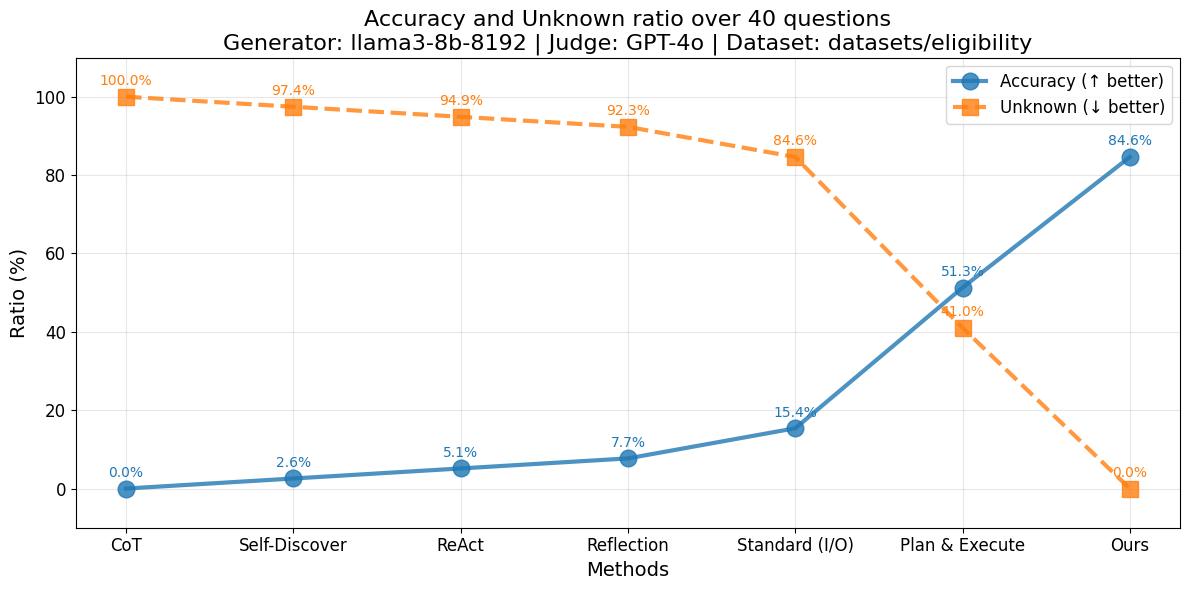

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple
from cama.utils import evaluate_answers_with_unknowns

# load qa list
qa_list = load_from_json(f'{dataset_folder}/qa_list.json')

def plot_scores_with_unknowns(scores: Dict[str, Tuple[float, float]], llm_name: str):
    """
    Creates a single line plot showing both accuracy scores and unknown ratios.

    Parameters:
    scores (Dict[str, Tuple[float, float]]): A dictionary where keys are method names and values are tuples (accuracy, unknown_ratio).
    llm_name (str): The name of the language model used as the report generator.
    """
    methods = list(scores.keys())
    accuracies = [score[0] for score in scores.values()]
    unknown_ratios = [score[1] for score in scores.values()]

    # Sort methods by accuracy for better visual trend
    sorted_indices = sorted(range(len(accuracies)), key=lambda k: accuracies[k])
    methods = [methods[i] for i in sorted_indices]
    accuracies = [accuracies[i] for i in sorted_indices]
    unknown_ratios = [unknown_ratios[i] for i in sorted_indices]

    plt.figure(figsize=(12, 6))

    # Plot both lines on the same graph
    plt.plot(methods, accuracies, marker='o', linewidth=3, color='#1f77b4', markersize=12, label='Accuracy (↑ better)', alpha=0.8)
    plt.plot(methods, unknown_ratios, marker='s', linewidth=3, color='#ff7f0e', markersize=12, label='Unknown (↓ better)', alpha=0.8, linestyle='--')
    
    # Highlight CAMA with different markers
    # cama_index = methods.index("CAMA") if "CAMA" in methods else -1
    # if cama_index != -1:
    #     plt.plot(cama_index, accuracies[cama_index], marker='*', markersize=20, color='#1f77b4', label='CAMA (Acc)', linewidth=0)
    #     plt.plot(cama_index, unknown_ratios[cama_index], marker='P', markersize=20, color='#ff7f0e', label='CAMA (Unk)', linewidth=0)
    
    plt.ylim(-10, 110)
    plt.xlabel('Methods', fontsize=14)
    plt.ylabel('Ratio (%)', fontsize=14)
    plt.title(f'Accuracy and Unknown ratio over 40 questions\nGenerator: {llm_name} | Judge: GPT-4o | Dataset: {dataset_folder}', fontsize=16)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # # Create a custom legend order
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 1]  # Accuracy, Unknown
    # if cama_index != -1:
    #     order.extend([2, 3])  # CAMA (Acc), CAMA (Unk)
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=12)

    # Add value labels on each point with offset for better readability
    for i, (acc, unk) in enumerate(zip(accuracies, unknown_ratios)):
        # if acc > unk:
        plt.text(i, acc + 3, f'{acc:.1f}%', ha='center', fontsize=10, color='#1f77b4')
        plt.text(i, unk + 3, f'{unk:.1f}%', ha='center', fontsize=10, color='#ff7f0e')
        # else:
        #     plt.text(i, acc - 2, f'{acc:.1f}%', ha='center', fontsize=10, color='#1f77b4')
        #     plt.text(i, unk + 2, f'{unk:.1f}%', ha='center', fontsize=10, color='#ff7f0e')

    # save plot in pdf
    # plt.savefig(f'{dataset_folder}/scores_plot_{llm_name}.pdf', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# Example usage:
scores = {
    "Standard (I/O)": evaluate_answers_with_unknowns(qa_list, answers_full_prompt),
    "CoT": evaluate_answers_with_unknowns(qa_list, answers_full_prompt_cot),
    "Ours": evaluate_answers_with_unknowns(qa_list, answers_cama_agent),
    "Reflection": evaluate_answers_with_unknowns(qa_list, answers_reflection),
    "ReAct": evaluate_answers_with_unknowns(qa_list, answers_react),
    "Self-Discover": evaluate_answers_with_unknowns(qa_list, answers_self_discover),
    "Plan & Execute": evaluate_answers_with_unknowns(qa_list, answers_plan_and_execute),
}

plot_scores_with_unknowns(scores, llm_name)